In [1]:
from torch_snippets import *
import selectivesearch

from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
##test change

'cuda'

In [2]:
import json
with open('/home/pawan/TII_IR-Tracking/src/Daytime/daytime.json', 'r') as f:
   coco_data = json.load(f)
   
images = coco_data['images']
file_names = [img['file_name'] for img in images]

In [ ]:
# Add into datastructure
image_ids_annotations = defaultdict(list)

for ann in coco_data['annotations']:
    image_id = ann['image_id'] # Are integers
    image_ids_annotations[image_id].append(ann)

# Get mapping category_id to category name
catergory_id_to_name = dict()
for ann in coco_data['categories']:
    catergory_id_to_name[ann['id']] = ann['name']

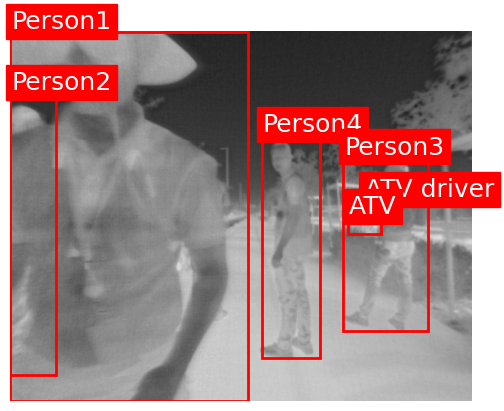

In [41]:
import matplotlib.patches as patches # For bounding boxes
image_name = "/home/pawan/TII_IR-Tracking/src/Daytime/IR/image0003.png"
image_id = int(image_name.split("image")[-1].split(".")[0])

img = Image.open(image_name)
fig, ax = plt.subplots()

# Add code to visualize boxes and labels
image_anns = image_ids_annotations[image_id]

# Get all bounding boxes and labels
for image_ann in image_anns:
    bbox = image_ann['bbox'] # Format: x, y, h, w, origin in top left corner
    name = catergory_id_to_name[image_ann['category_id']]

    # Extract bbox coordinates
    x = float(bbox[0])
    y = float(bbox[1])
    w = float(bbox[2])
    h = float(bbox[3])

    # Add text and bbox
    plt.text(x+1, y-5, name,fontdict={'fontsize':18.0, 'fontweight':'medium','color': 'white', 'backgroundcolor':'red'})
    bb = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(bb)

ax.axis('off')
ax.imshow(img)
plt.show()

In [ ]:
IMAGE_ROOT = "/home/pawan/TII_IR-Tracking/src/Daytime/IR/"
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()

    def __len__(self): return len(self.unique_images)

    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        print(image_path)
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
        
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10, text_sz=20)

# Candidate Extration and Intersect of Union(IoU)
Candidate exctraction is done using selective search and IoU measures the accuracy of the prediction 

In [ ]:
def extract_candidates(img):
    
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False


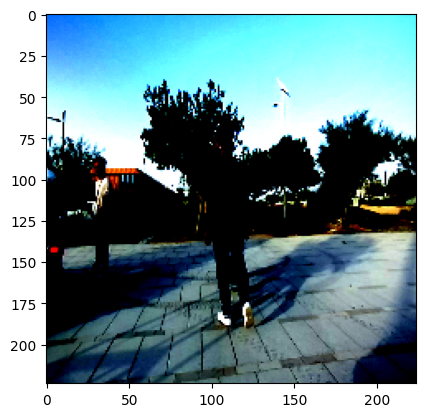

In [46]:
train_data_dir = '/home/pawan/TII_IR-Tracking/src/Daytime/RGB'
data = CatsDogs(train_data_dir)

im, label = data[1]
plt.imshow(im.permute(1,2,0).cpu())

In [4]:
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

IndexError: list index out of range

In [9]:
import json
with open('/home/pawan/TII_IR-Tracking/src/Daytime/daytime.json') as f:
   data = json.load(f)

print(len(data["annotations"]))

44275


In [9]:
class Test_Modle(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1,requires_grad=True,dtype=torch.float))

    def forward(self, x: torch.Tensor) -> torch.tensor:
        return self.weight * x + self.bias

inference mode will not keep track to the lerning parameters when testing your code so the model will run faster. 
*'with torch.inference_mode()' and be replaced with 'torch.no_grad()' but inference_mode is prefered

In [15]:
model_0 = Test_Modle()
model_0.state_dict()

OrderedDict([('weight', tensor([-1.3249])), ('bias', tensor([0.2253]))])

In [ ]:


with torch.inference_mode():
    y_pred = model_0(X_test)